In [1]:
import numpy as np
import nengo
import pandas
import nengolib
from nengolib.signal import s

import matplotlib.pyplot as plt
from nengo.utils.matplotlib import rasterplot
import seaborn as sns
sns.set(context='poster', style='whitegrid')
%matplotlib inline

from nengo_bioneurons import BahlNeuron, build_filter

/home/pduggins/.virtualenvs/nengo_bioneuron/local/lib/python2.7/site-packages/nengo/builder/builder.py:234: UserWarning: Type '<class 'nengo.connection.Connection'>' already has a builder. Overwriting.
  % nengo_class)


## Model and simulation methods

In [2]:
class Params(object):
    def __init__(self, seed):
        super(Params, self).__init__()
        self.rng = np.random.RandomState(seed=seed)
        self.net_seed = self.rng.randint(100)
        self.ens_seed = self.rng.randint(100)
        self.con_seed = self.rng.randint(100)
        self.sim_seed = self.rng.randint(100)
        self.n_wm = 1000
        self.n_inpt = 100
        self.n_dec = 200
        self.miss = 0.05
        # 1, -1, or 0 with probability "miss"
        self.cue = (2*self.rng.randint(2) - 1) * self.rng.choice([False, True],p=[self.miss, 1-self.miss])
        self.neuron_type = nengo.LIF()
        self.k_wm = 1.0
        self.tau_wm = 0.1
        self.tau_out = 0.02
        self.thresh_dec = 0.025
        self.noise_wm = 0.0295
        
        self.functional = {'control': 1.0, 'GFC': 1.01, 'PHE': 0.99}
        self.neural = {'control':[0.0, 0.0], 'PHE':[-0.2, 0.01], 'GFC':[0.2, -0.05]}

In [3]:
def make_network(p):
    with nengo.Network(seed=p.net_seed) as network:
        
        def f_dec(x):
            # if "dec" is above threshold and in the correct direction, output 1, else 0
            if x[0] > p.thresh_dec and p.cue > 0:
                return 1
            elif x[0] < -p.thresh_dec and p.cue < 0:
                return 1
            return 0
    
        cue = nengo.Node(lambda t: p.cue * (t < 1.0))
        inpt = nengo.Ensemble(p.n_inpt, 1, seed=p.ens_seed)
        wm = nengo.Ensemble(p.n_wm, 1, neuron_type=p.neuron_type, seed=p.ens_seed)
        dec = nengo.Ensemble(p.n_dec, 1, seed=p.ens_seed)  # , neuron_type=nengo.Direct()
        cor = nengo.Ensemble(1, 1, neuron_type=nengo.Direct(), seed=p.ens_seed)
        noise_wm = nengo.Node(nengo.processes.WhiteNoise(
            dist=nengo.dists.Gaussian(0, p.noise_wm), seed=p.sim_seed))
        
        c_cue = nengo.Connection(cue, inpt, synapse=None, seed=p.con_seed)
        c_inpt = nengo.Connection(inpt, wm, synapse=p.tau_wm, transform=p.tau_wm, seed=p.con_seed)
        c_wm = nengo.Connection(wm, wm, synapse=p.tau_wm, transform=p.k_wm, seed=p.con_seed)
        c_dec = nengo.Connection(wm, dec, synapse=p.tau_out, seed=p.con_seed)
        c_noise = nengo.Connection(noise_wm, wm.neurons, synapse=None,
                         transform=np.ones((p.n_wm, 1)), seed=p.con_seed)
        c_cor = nengo.Connection(dec, cor, synapse=p.tau_out,
                         function=f_dec, seed=p.con_seed)
        
        p_wm = nengo.Probe(wm, synapse=p.tau_out)
        p_spk = nengo.Probe(wm.neurons, synapse=None)
        p_cor = nengo.Probe(cor, synapse=None)
        
        network.wm = wm
        network.c_wm = c_wm
        network.c_dec = c_dec
        network.p_wm = p_wm
        network.p_spk = p_spk
        network.p_cor = p_cor

    return network

In [4]:
def simulate(p, network, verbose=False):
    with nengo.Simulator(network, seed=p.sim_seed, progress_bar=verbose) as sim:
        sim.run(9.0, progress_bar=verbose)
    return sim.trange(), sim.data[network.p_wm], sim.data[network.p_spk], sim.data[network.p_cor], sim.data[network.wm].encoders, sim.data[network.wm].gain

In [5]:
def run_trials(n_trials, drug, manipulation):
    wm_data = []
    spike_data = []
    output_data = []
    encoders = []
    gains = []
    for n in range(n_trials):
        print 'trial %s' %n
        p = Params(seed=n)
        if manipulation == 'functional':
            # perturb strength of recurrent connection by multiplier k_wm
            p.k_wm = p.functional[drug]
        network = make_network(p)
        if manipulation == 'neural':
            # build network once to draw default gains, biases, and wm recurrent weights
            sim = nengo.Simulator(network, seed=p.sim_seed, progress_bar=False)
            # scale gains and biases
            network.wm.gain = sim.data[network.wm].gain + p.neural[drug][0]
            network.wm.bias = sim.data[network.wm].bias + p.neural[drug][1]
            # fix the decoders on wm connections, so that nengo does not
            # optimize for the scaled gains and biases
            network.c_wm.solver = nengo.solvers.NoSolver(sim.model.params[network.c_wm].weights.T)
            network.c_dec.solver = nengo.solvers.NoSolver(sim.model.params[network.c_dec].weights.T)
        times, d_wm, d_spk, d_cor, enc, gn = simulate(p, network)
        wm_data.append(np.abs(d_wm))
        spike_data.append(d_spk)
        output_data.append(np.abs(d_cor))
        encoders.append(enc)
        gains.append(gn)
    return times, np.array(wm_data), np.array(spike_data), np.array(output_data), np.array(encoders), np.array(gains)

## Data analysis

In [6]:
def array_to_pandas(data, datatype, drug):
    n_trials = data.shape[0]
    n_timesteps = data.shape[1]
    columns = ('trial', 'drug', 'time', datatype)
    df = pandas.DataFrame(columns=columns)
    for trial in range(n_trials):
        print 'adding trial %s, drug %s to %s...' %(trial, drug, datatype)
        df_time = []
        for t in range(n_timesteps):
            df_temp = pandas.DataFrame(
                [[trial, drug + ' (model)', t*0.001, data[trial][t][0]]], columns=columns)
            df_time.append(df_temp)
            del df_temp
        df_trial = pandas.concat(df_time, ignore_index=True)
        df = pandas.concat([df, df_trial], ignore_index=True)
        del df_time
    return df

In [7]:
def spikes_to_pandas(spikes, encoders, gains, drug, tau, enc_min=99, enc_max=100):
    n_trials = spikes.shape[0]
    n_timesteps = spikes.shape[1]
    n_neurons = spikes.shape[2]
    columns = ('neuron-trial', 'drug', 'time', 'rate', 'tuning')
    df = pandas.DataFrame(columns=columns)
    for trial in range(n_trials):
        p = Params(seed=trial)
        for n in range(n_neurons):
            scaled_enc = encoders[trial][n][0] * gains[trial][n]
            if enc_min < scaled_enc < enc_max and p.cue == 1:
                tuning = 'preferred'
            elif -enc_max < scaled_enc < -enc_min and p.cue == -1:
                tuning = 'preferred'
            elif enc_min < scaled_enc < enc_max and p.cue == -1:
                tuning = 'nonpreferred'
            elif -enc_max < scaled_enc < -enc_min and p.cue == 1:
                tuning = 'nonpreferred'
            else:
                continue
            print 'adding trial %s, neuron %s (%s), drug %s to rates...' %(trial, n, tuning, drug)
            rates = nengo.Lowpass(tau).filt(spikes[trial, :, n])
            for t in range(n_timesteps):
                df_temp = pandas.DataFrame(
                    [[n+trial*n_neurons, drug + ' (model)', t*0.001, rates[t], tuning]],
                        columns=columns)
                df = pandas.concat([df, df_temp], ignore_index=True)
                del df_temp
    return df

In [8]:
def empirical_dataframe():
    q=0
    emp_times = [3.0,5.0,7.0,9.0]
    df_emp = pandas.DataFrame(
        columns=('time', 'drug', 'correct', 'trial'),
        index=np.arange(0, 12))
    pre_PHE=[0.972, 0.947, 0.913, 0.798]
    pre_GFC=[0.970, 0.942, 0.882, 0.766]
    post_GFC=[0.966, 0.928, 0.906, 0.838]
    post_PHE=[0.972, 0.938, 0.847, 0.666]
    for t in range(len(emp_times)):
        df_emp.loc[q]=[emp_times[t],'control (empirical)',np.average([pre_GFC[t],pre_PHE[t]]),0]
#         q+=1
        df_emp.loc[q+1]=[emp_times[t],'GFC (empirical)',post_GFC[t],0]
        df_emp.loc[q+2]=[emp_times[t],'PHE (empirical)',post_PHE[t],0]
        q+=3
    return df_emp

In [9]:
def plot_dataframe(df_wm, df_cor, df_emp):
    fig1, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 8))
    sns.tsplot(time='time', value='wm', unit='trial', condition='drug',
        data=df_wm, ax=ax1, ci=95, legend=False)
    ax1.set(ylabel='$|\hat{x}(t)|$', ylim=((0, 1)))
    sns.tsplot(time='time', value='correct', unit='trial', condition='drug',
        data=df_cor, ax=ax2, ci=95, alpha=0.5)
    sns.tsplot(time='time', value='correct', unit='trial', condition='drug',
        data=df_emp, ax=ax2, ci=95, marker='o')
    ax2.set(xlabel='time (s)', ylabel='accuracy', xlim=((0,10)), ylim=((0.5,1.0)))
    ax2.legend(loc='lower left')
    plt.show()

In [10]:
def plot_rates(df_rates):
    df_pref = pandas.DataFrame(df_rates.query("tuning=='preferred'")).reset_index()
    df_nopref = pandas.DataFrame(df_rates.query("tuning=='nonpreferred'")).reset_index()
    fig1, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 8))
    sns.tsplot(time='time', value='rate', unit='neuron-trial', condition='drug',
        data=df_pref, ax=ax1, ci=95)
    ax1.set(xlim=((0.1, 10.0)), ylim=((0, 300)), 
            xlabel='time (s)', ylabel='firing rate (Hz)', title='preferred')
    ax1.legend(loc='lower right')
    sns.tsplot(time='time', value='rate', unit='neuron-trial', condition='drug',
        data=df_nopref, ax=ax2, ci=95, legend=False)
    ax2.set(xlim=((0.1, 10.0)), ylim=((0, 300)), 
            xlabel='time (s)', ylabel='', title='nonpreferred')
    plt.tight_layout()
    plt.show()

In [11]:
def plot_emp_dataframe(df_emp):
    fig1, (ax2) = plt.subplots(1, 1, sharex=True, figsize=(8, 4))
    sns.tsplot(time='time', value='correct', unit='trial', condition='drug',
        data=df_emp, ax=ax2, ci=95, marker='o')
    ax2.set(xlabel='time (s)', ylabel='accuracy', xlim=((0,10)), ylim=((0.5,1.0)))
    ax2.legend(loc='lower left')
    plt.show()

## Functional Manipulation
Simulate drugs by altering the constant multiplier $k_{wm}$ on the recurrent connection

In [12]:
times, wm_data_con, spike_data_con, output_data_con, encoders_con, gains_con = run_trials(
    100, drug='control', manipulation='functional')

times, wm_data_gfc, spike_data_gfc, output_data_gfc, encoders_gfc, gains_gfc = run_trials(
    100, drug='GFC', manipulation='functional')

times, wm_data_phe, spike_data_phe, output_data_phe, encoders_phe, gains_phe = run_trials(
    100, drug='PHE', manipulation='functional')

trial 0
trial 1
trial 2
trial 3
trial 4
trial 5
trial 6
trial 7
trial 8
trial 9
trial 10
trial 11
trial 12
trial 13
trial 14
trial 15
trial 16
trial 17
trial 18
trial 19
trial 20
trial 21
trial 22
trial 23
trial 24
trial 25
trial 26
trial 27
trial 28
trial 29
trial 30
trial 31
trial 32
trial 33
trial 34
trial 35
trial 36
trial 37
trial 38
trial 39
trial 40
trial 41
trial 42
trial 43
trial 44
trial 45
trial 46
trial 47
trial 48
trial 49
trial 50
trial 51
trial 52
trial 53
trial 54
trial 55
trial 56
trial 57
trial 58
trial 59
trial 60
trial 61
trial 62
trial 63
trial 64
trial 65
trial 66
trial 67
trial 68
trial 69
trial 70
trial 71
trial 72
trial 73
trial 74
trial 75
trial 76
trial 77
trial 78
trial 79
trial 80
trial 81
trial 82
trial 83
trial 84
trial 85
trial 86
trial 87
trial 88
trial 89
trial 90
trial 91
trial 92
trial 93
trial 94
trial 95
trial 96
trial 97
trial 98
trial 99
trial 0
trial 1
trial 2
trial 3
trial 4
trial 5
trial 6
trial 7
trial 8
trial 9
trial 10
trial 11
trial 12
tri

adding trial 0, drug control to wm...
adding trial 1, drug control to wm...
adding trial 2, drug control to wm...
adding trial 3, drug control to wm...
adding trial 4, drug control to wm...
adding trial 5, drug control to wm...
adding trial 6, drug control to wm...
adding trial 7, drug control to wm...
adding trial 8, drug control to wm...
adding trial 9, drug control to wm...
adding trial 10, drug control to wm...
adding trial 11, drug control to wm...
adding trial 12, drug control to wm...
adding trial 13, drug control to wm...
adding trial 14, drug control to wm...
adding trial 15, drug control to wm...
adding trial 16, drug control to wm...
adding trial 17, drug control to wm...
adding trial 18, drug control to wm...
adding trial 19, drug control to wm...
adding trial 20, drug control to wm...
adding trial 21, drug control to wm...
adding trial 22, drug control to wm...
adding trial 23, drug control to wm...
adding trial 24, drug control to wm...
adding trial 25, drug control to wm

adding trial 99, drug control to correct...
adding trial 0, drug GFC to wm...
adding trial 1, drug GFC to wm...
adding trial 2, drug GFC to wm...
adding trial 3, drug GFC to wm...
adding trial 4, drug GFC to wm...
adding trial 5, drug GFC to wm...
adding trial 6, drug GFC to wm...
adding trial 7, drug GFC to wm...
adding trial 8, drug GFC to wm...
adding trial 9, drug GFC to wm...
adding trial 10, drug GFC to wm...
adding trial 11, drug GFC to wm...
adding trial 12, drug GFC to wm...
adding trial 13, drug GFC to wm...
adding trial 14, drug GFC to wm...
adding trial 15, drug GFC to wm...
adding trial 16, drug GFC to wm...
adding trial 17, drug GFC to wm...
adding trial 18, drug GFC to wm...
adding trial 19, drug GFC to wm...
adding trial 20, drug GFC to wm...
adding trial 21, drug GFC to wm...
adding trial 22, drug GFC to wm...
adding trial 23, drug GFC to wm...
adding trial 24, drug GFC to wm...
adding trial 25, drug GFC to wm...
adding trial 26, drug GFC to wm...
adding trial 27, drug

adding trial 20, drug PHE to wm...
adding trial 21, drug PHE to wm...
adding trial 22, drug PHE to wm...
adding trial 23, drug PHE to wm...
adding trial 24, drug PHE to wm...
adding trial 25, drug PHE to wm...
adding trial 26, drug PHE to wm...
adding trial 27, drug PHE to wm...
adding trial 28, drug PHE to wm...
adding trial 29, drug PHE to wm...
adding trial 30, drug PHE to wm...
adding trial 31, drug PHE to wm...
adding trial 32, drug PHE to wm...
adding trial 33, drug PHE to wm...
adding trial 34, drug PHE to wm...
adding trial 35, drug PHE to wm...
adding trial 36, drug PHE to wm...
adding trial 37, drug PHE to wm...
adding trial 38, drug PHE to wm...
adding trial 39, drug PHE to wm...
adding trial 40, drug PHE to wm...
adding trial 41, drug PHE to wm...
adding trial 42, drug PHE to wm...
adding trial 43, drug PHE to wm...
adding trial 44, drug PHE to wm...
adding trial 45, drug PHE to wm...
adding trial 46, drug PHE to wm...
adding trial 47, drug PHE to wm...
adding trial 48, dru

/home/pduggins/.virtualenvs/nengo_bioneuron/local/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


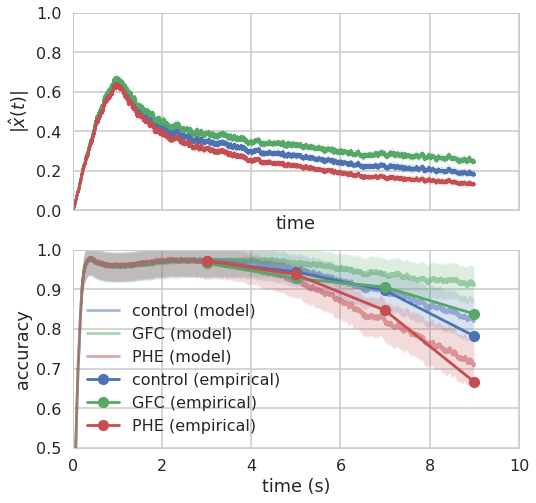

In [13]:
df_wm_con = array_to_pandas(wm_data_con, 'wm', 'control')
df_cor_con = array_to_pandas(output_data_con, 'correct', 'control')
df_wm_gfc = array_to_pandas(wm_data_gfc, 'wm', 'GFC')
df_cor_gfc = array_to_pandas(output_data_gfc, 'correct', 'GFC')
df_wm_phe = array_to_pandas(wm_data_phe, 'wm', 'PHE')
df_cor_phe = array_to_pandas(output_data_phe, 'correct', 'PHE')
df_wm = pandas.concat([df_wm_con, df_wm_gfc, df_wm_phe], ignore_index=True)
df_cor = pandas.concat([df_cor_con, df_cor_gfc, df_cor_phe], ignore_index=True)
df_emp = empirical_dataframe()

plot_dataframe(df_wm, df_cor, df_emp)

In [14]:
# WARNING -- super slow

# df_spk_con = spikes_to_pandas(spike_data_con, encoders_con, gains_con, 'control', 0.1)
# df_spk_gfc = spikes_to_pandas(spike_data_gfc, encoders_gfc, gains_gfc, 'GFC', 0.1)
# df_spk_phe = spikes_to_pandas(spike_data_phe, encoders_phe, gains_phe, 'PHE', 0.1)
# df_spk = pandas.concat([df_spk_con, df_spk_gfc, df_spk_phe], ignore_index=True)

# plot_rates(df_spk)

## Neural Manipulation
Simulate drugs by altering the gains and biases of WM neurons

In [15]:
times, wm_data_con, spike_data_con, output_data_con, encoders_con, gains_con = run_trials(
    100, drug='control', manipulation='neural')

times, wm_data_gfc, spike_data_gfc, output_data_gfc, encoders_gfc, gains_gfc = run_trials(
    100, drug='GFC', manipulation='neural')

times, wm_data_phe, spike_data_phe, output_data_phe, encoders_phe, gains_phe = run_trials(
    100, drug='PHE', manipulation='neural')

trial 0
trial 1
trial 2
trial 3
trial 4
trial 5
trial 6
trial 7
trial 8
trial 9
trial 10
trial 11
trial 12
trial 13
trial 14
trial 15
trial 16
trial 17
trial 18
trial 19
trial 20
trial 21
trial 22
trial 23
trial 24
trial 25
trial 26
trial 27
trial 28
trial 29
trial 30
trial 31
trial 32
trial 33
trial 34
trial 35
trial 36
trial 37
trial 38
trial 39
trial 40
trial 41
trial 42
trial 43
trial 44
trial 45
trial 46
trial 47
trial 48
trial 49
trial 50
trial 51
trial 52
trial 53
trial 54
trial 55
trial 56
trial 57
trial 58
trial 59
trial 60
trial 61
trial 62
trial 63
trial 64
trial 65
trial 66
trial 67
trial 68
trial 69
trial 70
trial 71
trial 72
trial 73
trial 74
trial 75
trial 76
trial 77
trial 78
trial 79
trial 80
trial 81
trial 82
trial 83
trial 84
trial 85
trial 86
trial 87
trial 88
trial 89
trial 90
trial 91
trial 92
trial 93
trial 94
trial 95
trial 96
trial 97
trial 98
trial 99
trial 0
trial 1
trial 2
trial 3
trial 4
trial 5
trial 6
trial 7
trial 8
trial 9
trial 10
trial 11
trial 12
tri

adding trial 0, drug control to wm...
adding trial 1, drug control to wm...
adding trial 2, drug control to wm...
adding trial 3, drug control to wm...
adding trial 4, drug control to wm...
adding trial 5, drug control to wm...
adding trial 6, drug control to wm...
adding trial 7, drug control to wm...
adding trial 8, drug control to wm...
adding trial 9, drug control to wm...
adding trial 10, drug control to wm...
adding trial 11, drug control to wm...
adding trial 12, drug control to wm...
adding trial 13, drug control to wm...
adding trial 14, drug control to wm...
adding trial 15, drug control to wm...
adding trial 16, drug control to wm...
adding trial 17, drug control to wm...
adding trial 18, drug control to wm...
adding trial 19, drug control to wm...
adding trial 20, drug control to wm...
adding trial 21, drug control to wm...
adding trial 22, drug control to wm...
adding trial 23, drug control to wm...
adding trial 24, drug control to wm...
adding trial 25, drug control to wm

adding trial 99, drug control to correct...
adding trial 0, drug GFC to wm...
adding trial 1, drug GFC to wm...
adding trial 2, drug GFC to wm...
adding trial 3, drug GFC to wm...
adding trial 4, drug GFC to wm...
adding trial 5, drug GFC to wm...
adding trial 6, drug GFC to wm...
adding trial 7, drug GFC to wm...
adding trial 8, drug GFC to wm...
adding trial 9, drug GFC to wm...
adding trial 10, drug GFC to wm...
adding trial 11, drug GFC to wm...
adding trial 12, drug GFC to wm...
adding trial 13, drug GFC to wm...
adding trial 14, drug GFC to wm...
adding trial 15, drug GFC to wm...
adding trial 16, drug GFC to wm...
adding trial 17, drug GFC to wm...
adding trial 18, drug GFC to wm...
adding trial 19, drug GFC to wm...
adding trial 20, drug GFC to wm...
adding trial 21, drug GFC to wm...
adding trial 22, drug GFC to wm...
adding trial 23, drug GFC to wm...
adding trial 24, drug GFC to wm...
adding trial 25, drug GFC to wm...
adding trial 26, drug GFC to wm...
adding trial 27, drug

adding trial 20, drug PHE to wm...
adding trial 21, drug PHE to wm...
adding trial 22, drug PHE to wm...
adding trial 23, drug PHE to wm...
adding trial 24, drug PHE to wm...
adding trial 25, drug PHE to wm...
adding trial 26, drug PHE to wm...
adding trial 27, drug PHE to wm...
adding trial 28, drug PHE to wm...
adding trial 29, drug PHE to wm...
adding trial 30, drug PHE to wm...
adding trial 31, drug PHE to wm...
adding trial 32, drug PHE to wm...
adding trial 33, drug PHE to wm...
adding trial 34, drug PHE to wm...
adding trial 35, drug PHE to wm...
adding trial 36, drug PHE to wm...
adding trial 37, drug PHE to wm...
adding trial 38, drug PHE to wm...
adding trial 39, drug PHE to wm...
adding trial 40, drug PHE to wm...
adding trial 41, drug PHE to wm...
adding trial 42, drug PHE to wm...
adding trial 43, drug PHE to wm...
adding trial 44, drug PHE to wm...
adding trial 45, drug PHE to wm...
adding trial 46, drug PHE to wm...
adding trial 47, drug PHE to wm...
adding trial 48, dru

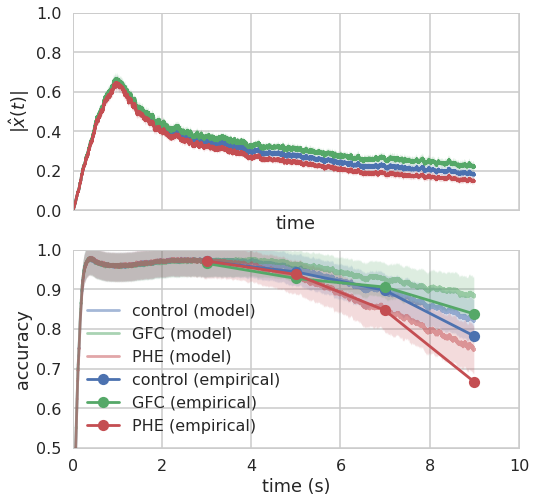

In [16]:
df_wm_con = array_to_pandas(wm_data_con, 'wm', 'control')
df_cor_con = array_to_pandas(output_data_con, 'correct', 'control')
df_wm_gfc = array_to_pandas(wm_data_gfc, 'wm', 'GFC')
df_cor_gfc = array_to_pandas(output_data_gfc, 'correct', 'GFC')
df_wm_phe = array_to_pandas(wm_data_phe, 'wm', 'PHE')
df_cor_phe = array_to_pandas(output_data_phe, 'correct', 'PHE')
df_wm = pandas.concat([df_wm_con, df_wm_gfc, df_wm_phe], ignore_index=True)
df_cor = pandas.concat([df_cor_con, df_cor_gfc, df_cor_phe], ignore_index=True)
df_emp = empirical_dataframe()

plot_dataframe(df_wm, df_cor, df_emp)

In [17]:
# WARNING -- super slow

# df_spk_con = spikes_to_pandas(spike_data_con, encoders_con, gains_con, 'control', 0.1)
# df_spk_gfc = spikes_to_pandas(spike_data_gfc, encoders_gfc, gains_gfc, 'GFC', 0.1)
# df_spk_phe = spikes_to_pandas(spike_data_phe, encoders_phe, gains_phe, 'PHE', 0.1)
# df_spk = pandas.concat([df_spk_con, df_spk_gfc, df_spk_phe], ignore_index=True)

# plot_rates(df_spk)